In [1]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype()
print(covtype.data.shape)

(581012, 54)


In [3]:
import random
random_numbers = random.sample(range(covtype.data.shape[0]), 10000)
sample = covtype.data[random_numbers,:]

In [6]:
# Preprocese los datos y reduzca la dimensionalidad del sample de manera que retenga el 90% de la varianza
from sklearn import preprocessing
from sklearn.decomposition import PCA

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(sample)

n_components = 54
pca = PCA(n_components=n_components)
pca.fit(X)

def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

n_components = min_var(0.9, pca.explained_variance_ratio_)
print(n_components)

20


In [7]:
pca90 = PCA(n_components=n_components)
X_pca90 = pca90.fit_transform(X)

Para k=  5 Silhouette score promedio:  0.30528166808455076
Para k=  6 Silhouette score promedio:  0.25832915564661163
Para k=  7 Silhouette score promedio:  0.33906915450049974
Para k=  8 Silhouette score promedio:  0.26953435306982276
Para k=  9 Silhouette score promedio:  0.25090518528915423
Para k=  10 Silhouette score promedio:  0.30443800562332557


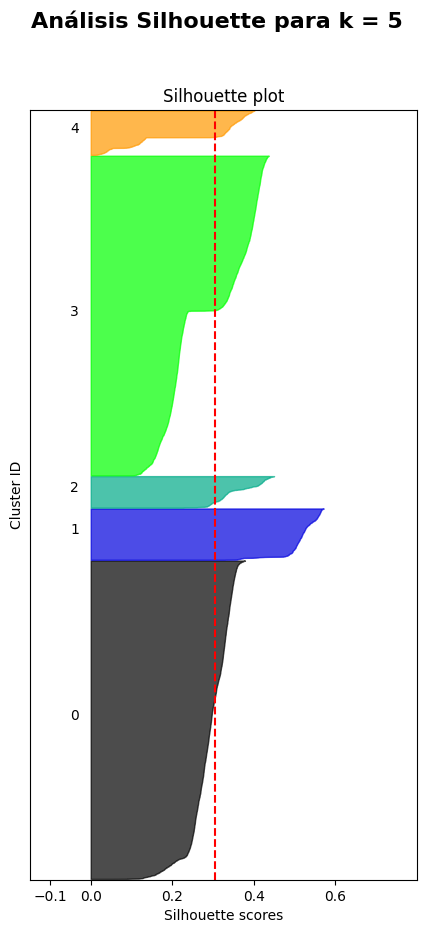

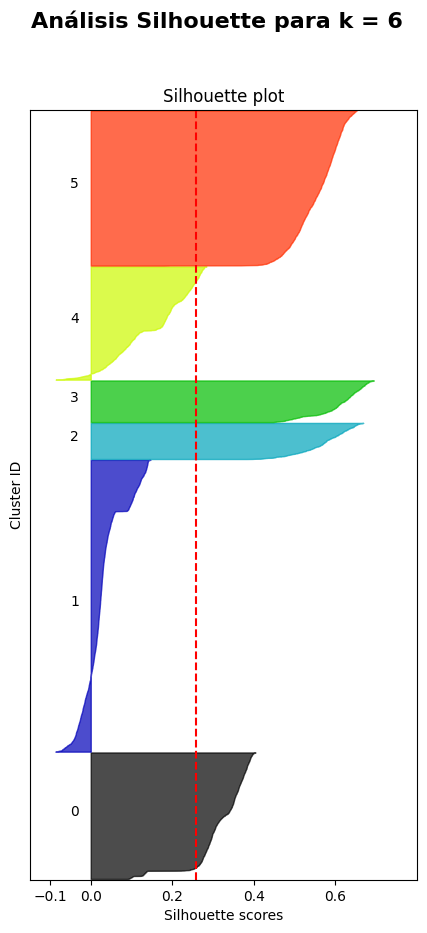

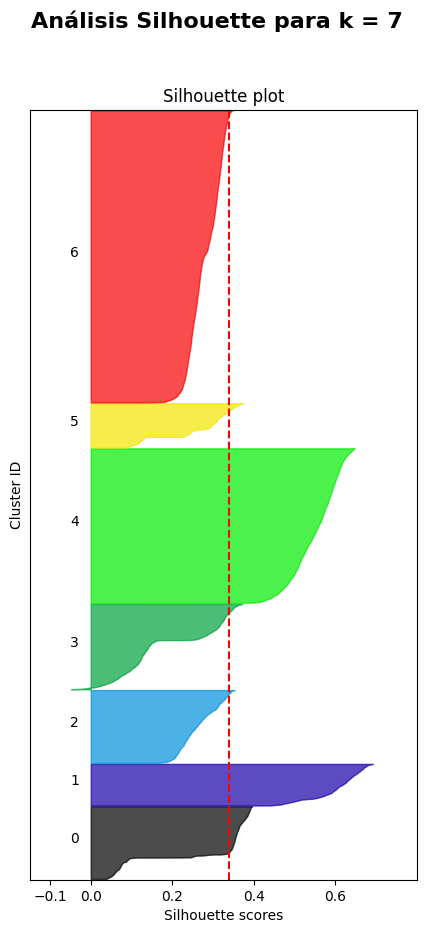

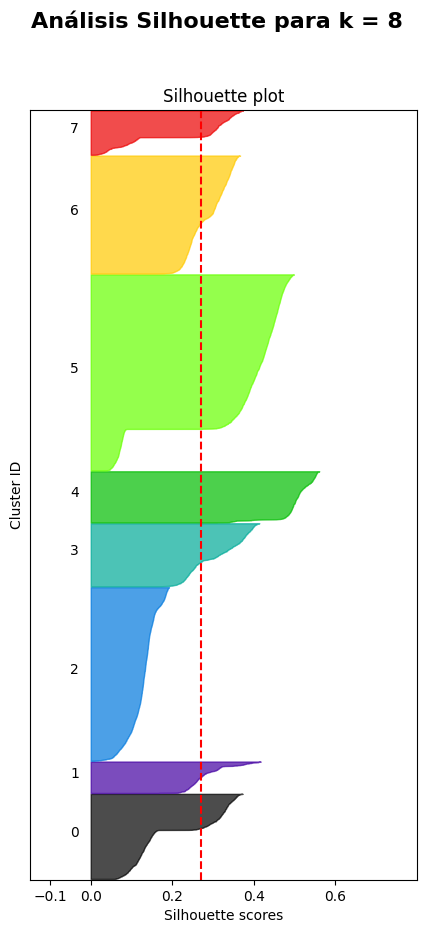

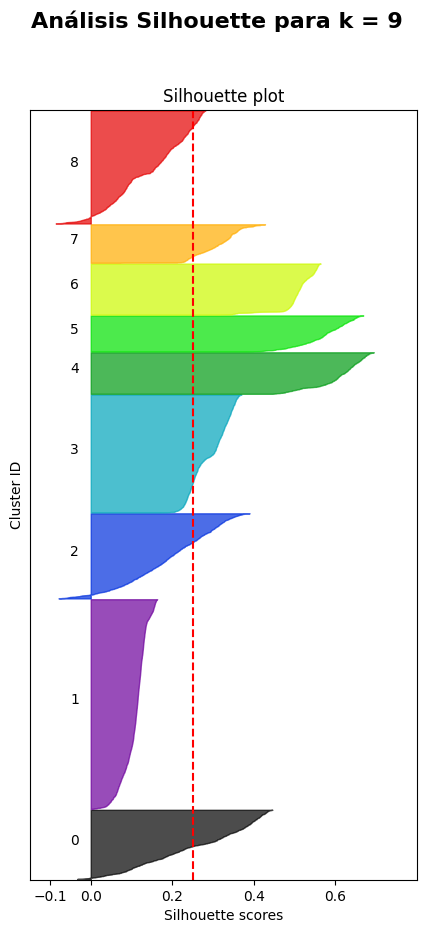

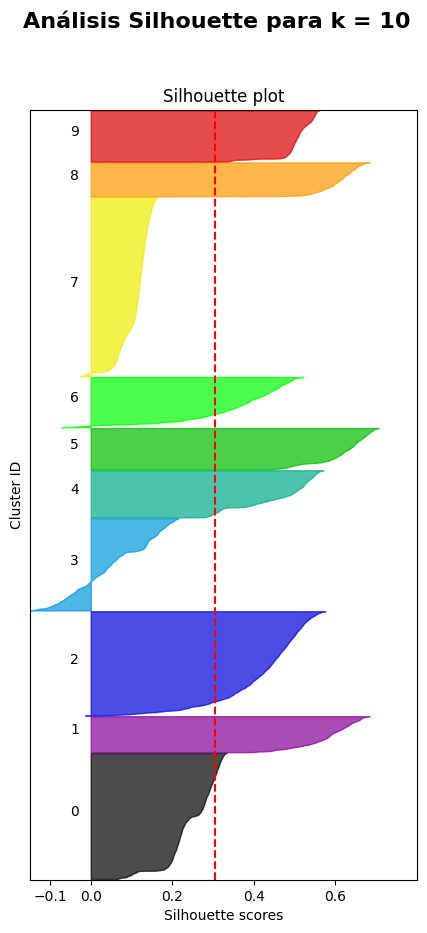

In [11]:
# Corra k-means con inicializacion random para valores de k en el rango de 5 a 10
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    
    fig, ax = plt.subplots(figsize=(5, 10))

    ax.set_xlim([-0.15, 0.8])
    ax.set_ylim([0, len(X_pca90) + (n_clusters + 1) * 10])
    
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4)
    estimator = make_pipeline(preprocessing.MinMaxScaler(), kmeans).fit(X_pca90)

    cluster_labels = estimator.fit_predict(X_pca90)

    silhouette_avg = silhouette_score(X_pca90, cluster_labels)
    print(
        "Para k= ",
        n_clusters,
        "Silhouette score promedio: ",
        silhouette_avg,
    )

    
    sample_silhouette_values = silhouette_samples(X_pca90, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster ID")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([]) 
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])


    plt.suptitle(
        "Análisis Silhouette para k = %d"
        % n_clusters,
        fontsize=16,
        fontweight="bold",
    )

plt.show()

En cuanto a score el con k=7 es el mejor, pero en cuanto a los silhoutte usaria el k=8 pues la mayoria de los datos estan más cerca del promedio  

In [14]:
# Elimine outliers en base al histograma de LOF
import numpy as np

def plot_hist(X, title):
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.85)
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))

def lof_threshold(v, scores):
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold

In [16]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(X_pca90)
scores = lof.negative_outlier_factor_

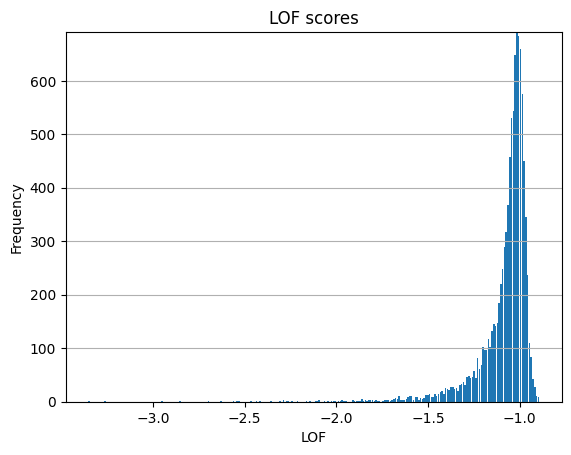

In [17]:
plot_hist(scores, 'LOF scores')

In [20]:
lof_threshold(-1.7, scores)

0.0096

In [24]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0096)
labels = lof.fit_predict(X_pca90)
indices = list(np.where(labels==1)[0])
new_X = X_pca90[indices,:]

Para k=  5 Silhouette score promedio:  0.2514032404885921
Para k=  6 Silhouette score promedio:  0.22772654586941565
Para k=  7 Silhouette score promedio:  0.280669947515184
Para k=  8 Silhouette score promedio:  0.2879583686504102
Para k=  9 Silhouette score promedio:  0.32462450639409535
Para k=  10 Silhouette score promedio:  0.3587455836123264


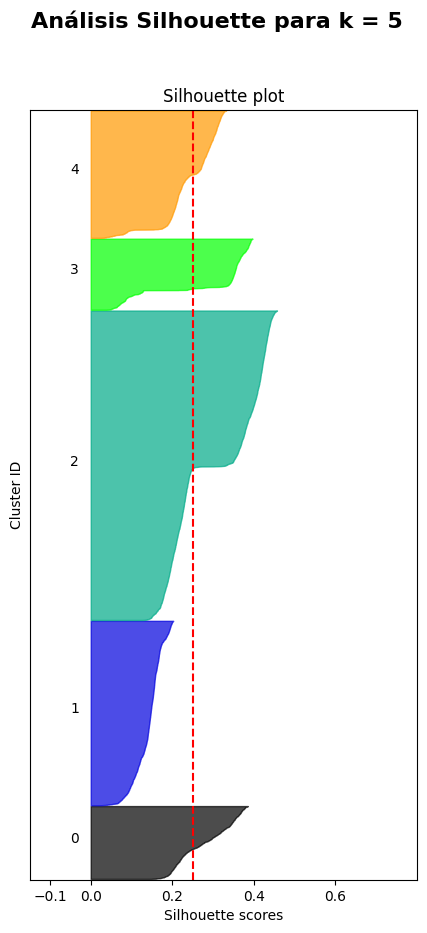

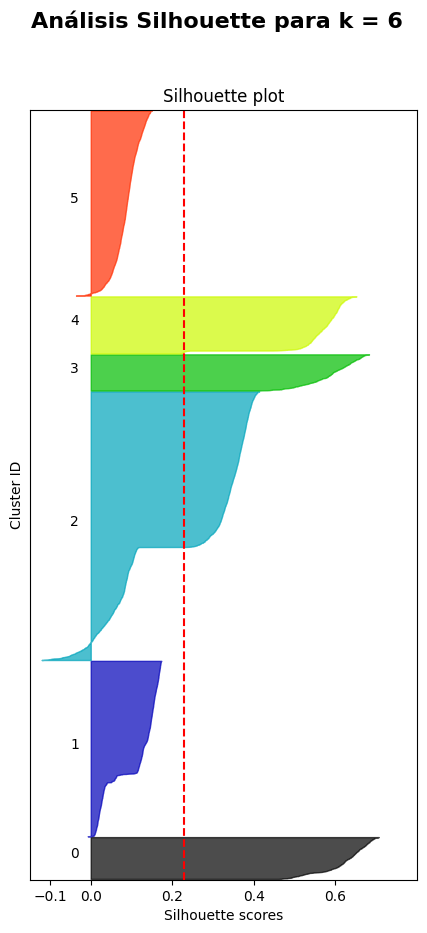

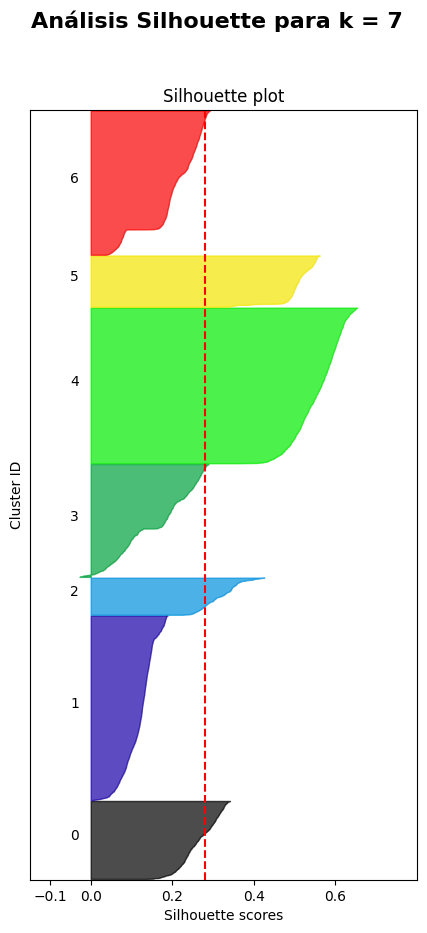

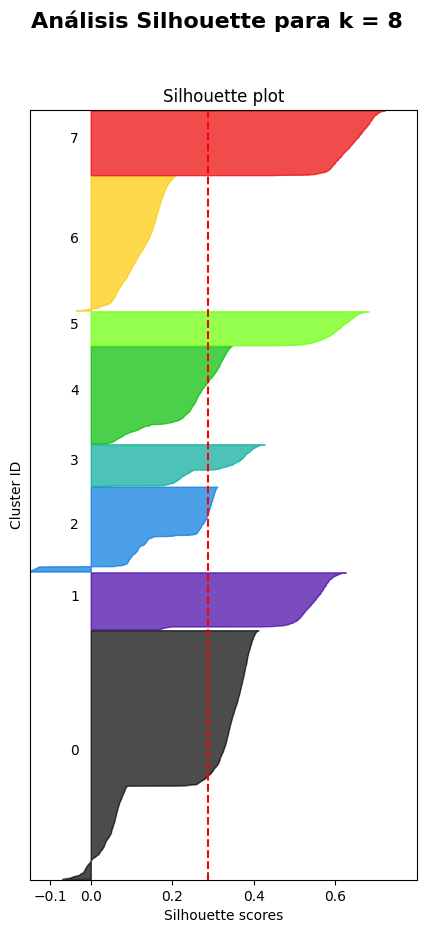

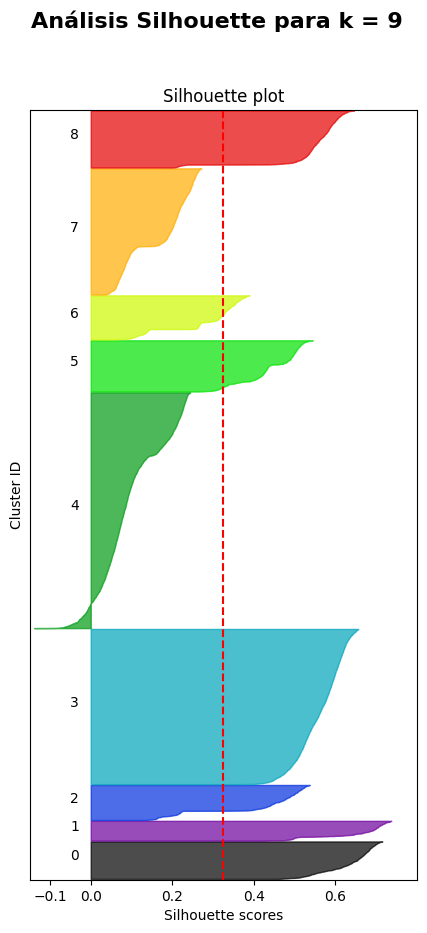

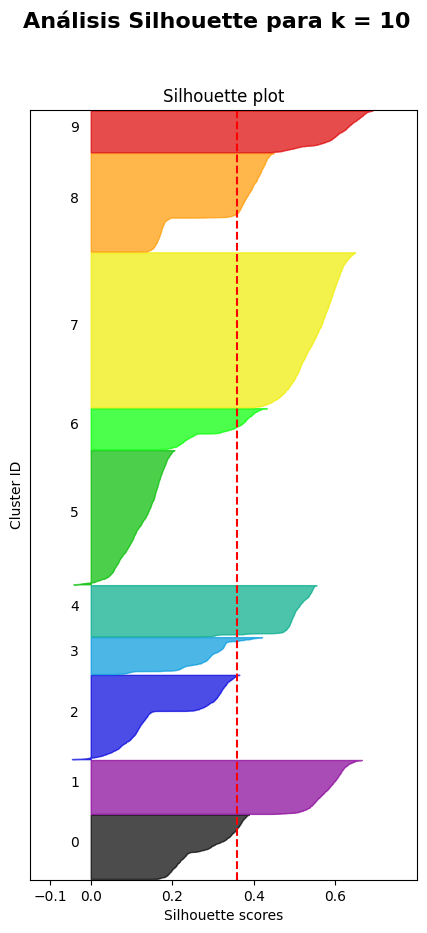

In [25]:
range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    
    fig, ax = plt.subplots(figsize=(5, 10))

    ax.set_xlim([-0.15, 0.8])
    ax.set_ylim([0, len(new_X) + (n_clusters + 1) * 10])
    
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4)
    estimator = make_pipeline(preprocessing.MinMaxScaler(), kmeans).fit(new_X)

    cluster_labels = estimator.fit_predict(new_X)

    silhouette_avg = silhouette_score(new_X, cluster_labels)
    print(
        "Para k= ",
        n_clusters,
        "Silhouette score promedio: ",
        silhouette_avg,
    )

    
    sample_silhouette_values = silhouette_samples(new_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster ID")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([]) 
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])


    plt.suptitle(
        "Análisis Silhouette para k = %d"
        % n_clusters,
        fontsize=16,
        fontweight="bold",
    )

plt.show()